![](img/571_banner.png)

# Lecture 7: Naive Bayes

UBC Master of Data Science program, 2022-23

Instructor: Varada Kolhatkar


## Imports

In [1]:
import os
import sys

sys.path.append("code/.")

import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML
from plotting_functions import *

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)

%matplotlib inline
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from utils import *

pd.set_option("display.max_colwidth", 200)

## Lecture learning objectives

From this lecture, you will be able to 

- Explain the naive assumption of naive Bayes. 
- Predict targets by hand on toy examples using naive Bayes.
- Use `scikit-learn`'s `MultiNomialNB`, `BernoulliNB`, and `GaussianNB`. 
- Use `predict_proba` for different classifiers and explain its usefulness. 
- Explain the need of smoothing in naive Bayes.
- Explain how `alpha` controls the fundamental tradeoff. 
- Use naive Bayes for multi-class classification. 
- Name advantages and disadvantages of naive Bayes. 

## Motivating example


### Example: spam/non spam
Last week in your lab you worked on spam classification using `SVC` classifier. 

$X = \begin{bmatrix}\text{"URGENT!! You have been selected to receive a £900 prize reward!",}\\ \text{"Lol your always so convincing."}\\ \text{"Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now!"}\\ \end{bmatrix}$ and $y = \begin{bmatrix}\text{spam} \\ \text{non spam} \\ \text{spam} \end{bmatrix}$


ML algorithms we have seen so far prefer fixed length numeric input that looks like this: 

$X = \begin{bmatrix}1.0 & 4.0 & \ldots & & 3.0\\ 0.0 & 2.0 & \ldots & & 6.0\\ 1.0 & 0.0 & \ldots & & 0.0\\ \end{bmatrix}$ and $y = \begin{bmatrix}\text{spam} \\ \text{non spam} \\ \text{spam} \end{bmatrix}$


#### `CountVectorizer` to get bag-of-words (BOW) representation

- So we used `CountVectorizer` to convert text data into feature vectors where
    - each feature is a unique word in the text  
    - each feature value represents the frequency or presence/absence of the word in the given message         
<center>    
<img src='./img/bag-of-words.png' width="800">
</center>        

[Source](https://web.stanford.edu/~jurafsky/slp3/4.pdf)       

### Naive Bayes

- For years, best spam filtering methods used naive Bayes.
- For example, [SpamAssassin](https://spamassassin.apache.org/) is a spam filtering system based on naive Bayes. 
- Even today naive Bayes forms a basis for many disease diagnosis and spam filtering systems.
- At some point it was one of the most widely used learner at Google.  

<br><br><br><br>

## Naive Bayes classifier

- Our first probabilistic classifier where we think of learning as a problem of statistical inference.

Before understanding the theory, let's try `scikit-learn`'s implementation of Naive Bayes on Kaggle's [SMS Spam Collection Dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset).

In [2]:
sms_df = pd.read_csv("data/spam.csv", encoding="latin-1")
sms_df = sms_df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
sms_df = sms_df.rename(columns={"v1": "target", "v2": "sms"})

In [3]:
train_df, test_df = train_test_split(sms_df, test_size=0.2, random_state=123)
X_train, y_train = train_df["sms"], train_df["target"]
X_test, y_test = test_df["sms"], test_df["target"]
train_df.head()

,target,sms
385,ham,It took Mr owl 3 licks
4003,ham,Well there's a pattern emerging of my friends telling me to drive up and come smoke with them and then telling me that I'm a weed fiend/make them smoke too much/impede their doing other things so ...
1283,ham,Yes i thought so. Thanks.
2327,spam,"URGENT! Your mobile number *************** WON a å£2000 Bonus Caller prize on 10/06/03! This is the 2nd attempt to reach you! Call 09066368753 ASAP! Box 97N7QP, 150ppm"
1103,ham,Aiyah sorry lor... I watch tv watch until i forgot 2 check my phone.


### SVC classifier for spam detection 

- Let's try SVC classifier on our dataset. (This is what you did in the lab last week.)

In [4]:
results_dict = {}
pipe_svc = make_pipeline(CountVectorizer(), SVC())
results_dict["SVC"] = mean_std_cross_val_scores(
    pipe_svc, X_train, y_train, return_train_score=True
)

In [5]:
pd.DataFrame(results_dict)

,SVC
fit_time,0.400 (+/- 0.004)
score_time,0.097 (+/- 0.001)
test_score,0.978 (+/- 0.005)
train_score,0.995 (+/- 0.001)


### `sklearn` naive Bayes classifier 

- Let's try Naive Bayes on this problem. 

In [6]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

pipe_nb = make_pipeline(CountVectorizer(), MultinomialNB())
results_dict["Naive Bayes"] = mean_std_cross_val_scores(
    pipe_nb, X_train, y_train, return_train_score=True
)

In [7]:
pd.DataFrame(results_dict)

,SVC,Naive Bayes
fit_time,0.400 (+/- 0.004),0.028 (+/- 0.001)
score_time,0.097 (+/- 0.001),0.006 (+/- 0.000)
test_score,0.978 (+/- 0.005),0.986 (+/- 0.003)
train_score,0.995 (+/- 0.001),0.993 (+/- 0.001)


- The validation scores are a bit better on this particular dataset.
- Much faster than the SVC classifier!! 

In [8]:
pipe_nb.fit(X_train, y_train)
deploy_test = ["URGENT! Free!!", "Let's enjoy the last week of block 2!"]
pipe_nb.predict(deploy_test)

array(['spam', 'ham'], dtype='<U4')

### Frequency of words in spam vs. non-spam

In [9]:
spam_train_df = train_df[train_df['target'] == 'spam']
ham_train_df = train_df[train_df['target'] == 'ham']

In [10]:
countvec_spam = CountVectorizer(binary=True, stop_words='english')
spam_train_vec = countvec_spam.fit_transform(spam_train_df['sms'])
spam_features = countvec_spam.get_feature_names_out()

You need to install the following package in order to run the code below. 

```conda install -c districtdatalabs yellowbrick```

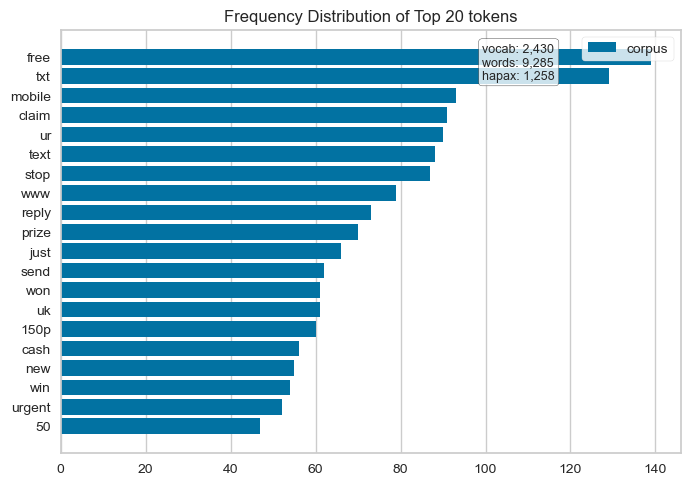

In [11]:
from yellowbrick.text import FreqDistVisualizer
visualizer = FreqDistVisualizer(features=spam_features, n=20)
visualizer.fit(spam_train_vec)
visualizer.show();

Let's examine the top words for class "ham". 

In [12]:
countvec_ham = CountVectorizer(binary=True, stop_words='english')
ham_train_vec = countvec_ham.fit_transform(ham_train_df['sms'])
ham_features = countvec_ham.get_feature_names_out()

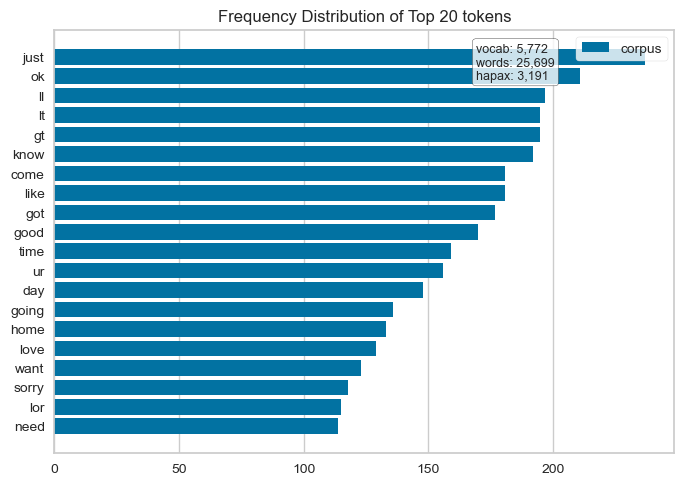

In [13]:
from yellowbrick.text import FreqDistVisualizer
visualizer = FreqDistVisualizer(features=ham_features, n=20)
visualizer.fit(ham_train_vec)
visualizer.show();

### Naive Bayes `predict`

- Given a new message, we want to predict whether it's spam or non spam (ham).
- Example: Predict whether the following message is spam or non spam (ham). 
> "URGENT! Free!!"
- For simplicity, let's use `CountVectorizer` with `binary=True`, i.e., assume presence or absence of words instead of counts.   

### Probabilistic classifiers: `predict` by hand 

- What is it doing under the hood? 
- Let's look at an example with a toy dataset. 

In [14]:
X_toy = [
    "URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!",
    "Lol you are always so convincing. I'm going to give you a free advice. It's urgent.",
    "Block 2 has interesting courses.",
    "URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!",
    "Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free!",
    "Block 2 has been great so far.",
]
y_toy = ["spam", "non spam", "non spam", "spam", "spam", "non spam"]

In [15]:
vec = CountVectorizer(max_features=4, stop_words="english", binary=True)
X_toy_vec = vec.fit_transform(X_toy, y_toy)

In [16]:
train_bow_df = pd.DataFrame(
    X_toy_vec.toarray(), columns=vec.get_feature_names_out(), index=X_toy
)
train_bow_df["target"] = y_toy
train_bow_df

,block,free,prize,urgent,target
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,0,0,1,1,spam
Lol you are always so convincing. I'm going to give you a free advice. It's urgent.,0,1,0,1,non spam
Block 2 has interesting courses.,1,0,0,0,non spam
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,0,1,1,1,spam
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free!,0,1,0,0,spam
Block 2 has been great so far.,1,0,0,0,non spam


In [17]:
X_toy_vec

<6x4 sparse matrix of type '<class 'numpy.int64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [18]:
spam_msgs = train_bow_df[train_bow_df['target'] == 'spam']
nonspam_msgs = train_bow_df[train_bow_df['target'] == 'non spam']

Suppose we are given text messages in `deploy_test` and we want to find the targets for these examples, how do we do it using naive Bayes?

First, let's get numeric representation of our text messages. 

In [19]:
deploy_test = ["URGENT! Free!!", "I like block 2."]
deploy_bow = vec.transform(deploy_test).toarray()
bow_df = pd.DataFrame(
    deploy_bow, columns=vec.get_feature_names_out(), index=deploy_test
)
bow_df

,block,free,prize,urgent
URGENT! Free!!,0,1,0,1
I like block 2.,1,0,0,0


### Naive Bayes prediction idea

Suppose we want to predict whether the following message is "spam" or "non spam".
> "URGENT! Free!!"

Representation of the message: `[0, 1, 0, 1]`

To predict the correct class, naive Bayes calculates the following probability scores. 

- $P(\text{spam} \mid \text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent=1})$ 
- $P(\text{non spam} \mid  \text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent=1})$
- Picks the label with higher probability score. 

### How do we calculate these probabilities? 

- Uses Bayes' theorem to calculate probabilities:

$$P(A \mid B) = \frac{P(B \mid A) \times P(A)}{P(B)}$$

$$P(\text{spam} \mid \text{message})= \frac{P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1 \mid \text{spam}) \times P(\text{spam})}{P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent=1})}$$

<br><br>

$$P(\text{non spam} \mid \text{message}) = \frac{P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1 \mid \text{non spam}) \times P( \text{non spam})}{P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent=1})}$$

We need the following probabilities

#### $P(\text{spam})$ and $P(\text{non spam})$
- marginal probability that a message is spam
- marginal probability that a message is non spam

<img src='./img/prior_prob.png' width="500">

### $P(\text{message})$
- marginal probability that a message has the given set of words 
    - Hard to calculate but can be ignored in our scenario as it occurs in the denominator for both $P(\text{spam} \mid \text{message})$ and $P(\text{non spam} \mid \text{message})$.
    - So we ignore the denominator in both cases.

<img src='./img/prob_message.png' width="500">

#### $P(\text{message} \mid \text{spam})$
- conditional probability that message has words $w_1, w_2, \dots, w_d$, given that it is spam.   
- $P(\text{message}\mid\text{spam})$ is hard to calculate because it requires a huge numbers of parameters and impossibly large training sets. 
- In our toy example: 
    - $P(\text{message}\mid\text{spam}) = $$P(\text{block} = 0 \mid spam) \times P(\text{free} = 1 \mid spam, \text{block} = 0) \times P(\text{prize} = 0\mid spam, \text{block} = 0, \text{free} = 1) \times P(\text{urgent} = 0\mid spam, \text{block} = 0, \text{free} = 1, \text{prize} = 0)$
    - with large number of features, it would require huge numbers of parameters and impossibly large training sets. 
    - For example, imagine how hard it would be to estimate probability of the 30,000th feature, given the previous 29,999 features.

...But we need this probability. So we start making assumptions. 

### Naive Bayes' approximation to calculate $P(\text{message}|\text{spam})$

- A common assmption is **naive Bayes** assumption, which states that **features are independent, conditioned on the target**. 
    - Example: In our spam classification example, **once you know that a message is spam**, the probability that the word "urgent" appears is independent of whether "free" also appeared. 
    - So if you know that a message is spam, knowing whether the word "urgent" occurs gives no additional information about whether "free" also appears. 
    
- We can write this mathematically as 

$$\begin{equation}
\begin{split}
& P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1 \mid \text{spam}) \\
&\approx P(\text{block} = 0 \mid \text{spam}) \times P(\text{free} = 1 \mid \text{spam}) \times P(\text{prize} = 0 \mid \text{spam}) \times P(\text{urgent} = 1 \mid \text{spam})
\end{split}
\end{equation}$$


### Naive Bayes' approximation

- In general, 
$$P(\text{message} \mid \text{spam}) = P(w_1, w_2, . . . , w_d \mid \text{spam}) \approx \prod_{i=1}^{d}P(w_i \mid \text{spam})$$

$$P(\text{message} \mid \text{non spam}) = P(w_1, w_2, . . . , w_d \mid \text{non spam}) \approx \prod_{i=1}^{d}P(w_i \mid \text{non spam})$$


### Going back to estimating $P(\text{spam} \mid \text{message})$

With naive Bayes' assumption, to calculate $P(\text{spam} \mid \text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1)$, we need the following:  
1. Prior probability: $P(\text{spam})$ 
2. Conditional probabilities: 
    1. $P(\text{block} = 0 \mid \text{spam})$
    2. $P(\text{free} = 1 \mid \text{spam})$
    3. $P(\text{prize} = 0 \mid \text{spam})$
    4. $P(\text{urgent} = 1 \mid \text{spam})$

We use our training data to estimate these probabilities. 

In [20]:
train_bow_df

,block,free,prize,urgent,target
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,0,0,1,1,spam
Lol you are always so convincing. I'm going to give you a free advice. It's urgent.,0,1,0,1,non spam
Block 2 has interesting courses.,1,0,0,0,non spam
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,0,1,1,1,spam
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free!,0,1,0,0,spam
Block 2 has been great so far.,1,0,0,0,non spam


- Prior probability: how often spam class occurs in our dataset. 
    - $P(\text{spam}) = 3/6$
    
- Conditional probabilities
    - What is $P(\text{block} = 0 \mid \text{spam})$? 
        - Given target is spam, how often "block" = 0? $3/3$
    - $P(\text{free} = 1 \mid \text{spam}) = 2/3$ 
    - $P(\text{prize} = 0 \mid \text{spam}) = 1/3$
    - $P(\text{urgent} = 1 \mid \text{spam}) = 2/3$

### Estimating $P(\text{spam} \mid \text{message})$

- After ignoring the denominator: 
$$\begin{equation}
\begin{split}
P(\text{spam} \mid \text{message}) &\propto P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1 \mid \text{spam}) \times P(\text{spam})\\
&\propto P(\text{block} = 0 \mid \text{spam}) \times P(\text{free} = 1 \mid \text{spam}) \\
& \times P(\text{prize} = 0 \mid \text{spam}) \times P(\text{urgent} = 1 \mid \text{spam}) \times P(\text{spam})\\
&\propto 3/3 \times 2/3 \times 1/3 \times 2/3 \times 3/6\\
\end{split}
\end{equation}$$


In [21]:
spam_prior = 3 / 6
block0_spam = 3 / 3
free1_spam = 2 / 3
prize0_spam = 1 / 3
urgent1_spam = 2 / 3
spam_estimate = spam_prior * block0_spam * free1_spam * prize0_spam * urgent1_spam
spam_estimate

0.07407407407407407

### Let's estimate $P(\text{non spam} \mid \text{message})$

With naive Bayes' assumption, to calculate $P(\text{non spam} \mid \text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1)$, we need the following:  
1. Prior probability: $P(\text{non spam})$ 
2. Conditional probabilities: 
    1. $P(\text{block} = 0 \mid \text{non spam})$
    2. $P(\text{free} = 1 \mid \text{non spam})$
    3. $P(\text{prize} = 0 \mid \text{non spam})$
    4. $P(\text{urgent} = 1 \mid \text{non spam})$

Again we use the data to estimate these probabilities. 

In [22]:
train_bow_df

,block,free,prize,urgent,target
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,0,0,1,1,spam
Lol you are always so convincing. I'm going to give you a free advice. It's urgent.,0,1,0,1,non spam
Block 2 has interesting courses.,1,0,0,0,non spam
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,0,1,1,1,spam
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free!,0,1,0,0,spam
Block 2 has been great so far.,1,0,0,0,non spam


- Prior probability 
    - $P(\text{non spam}) = 3/6$

- Conditional probabilities 
    - What is $P(\text{block} = 0 \mid \text{non spam})$? 
        - Given target is non spam, how often "block" = 0? $1/3$
    - $P(\text{free} = 1 \mid \text{non spam}) = 1/3$ 
    - $P(\text{prize} = 0 \mid \text{non spam}) = 3/3$
    - $P(\text{urgent} = 1 \mid \text{non spam}) = 1/3$

### Estimating $P(\text{non spam} \mid \text{message})$

$$\begin{equation}
\begin{split}
P(\text{non spam} \mid \text{message}) &\propto P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1 \mid \text{non spam}) \times P(\text{non spam})\\
&\propto P(\text{block} = 0 \mid \text{non spam}) \times P(\text{free} = 1 \mid \text{non spam}) \\
& \times P(\text{prize} = 0 \mid \text{non spam}) \times P(\text{urgent} = 1 \mid \text{non spam}) \times P(\text{non spam})\\
&\propto 1/3 \times 1/3 \times 3/3 \times 1/3 \times 3/6\\
\end{split}
\end{equation}$$


In [23]:
non_spam_prior = 3 / 6
block0_non_spam = 1 / 3
free1_non_spam = 1 / 3
prize0_non_spam = 3 / 3
urgent1_non_spam = 1 / 3
non_spam_estimate = (
    non_spam_prior
    * block0_non_spam
    * free1_non_spam
    * prize0_non_spam
    * urgent1_non_spam
)
non_spam_estimate

0.018518518518518517

In [24]:
print('spam estimate: ', spam_estimate)
print('non spam estimate: ', non_spam_estimate)

spam estimate:  0.07407407407407407
non spam estimate:  0.018518518518518517


Since $P(spam \mid message)$ is proportional to a bigger number, we pick "spam" as the label.

- Note that these estimates are not well-defined probabilities, as we ignored the denominator when calculating these estimates. 
- Let's normalize these estimates so that they sum to 1.0 

In [25]:
normalizer = spam_estimate + non_spam_estimate
spam_prob_score = spam_estimate / normalizer
non_spam_prob_score = non_spam_estimate / normalizer
[non_spam_prob_score, spam_prob_score]

[0.2, 0.8]

Let's examine whether we get the same numbers with `sklearn`'s `BernoulliNB`. 
- We are using `BernoulliNB` because our features are binary. 

In [26]:
nb = BernoulliNB(alpha=0)
nb.fit(X_toy_vec, y_toy)

/Users/kvarada/opt/miniconda3/envs/571/lib/python3.10/site-packages/sklearn/naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


BernoulliNB(alpha=0)

- We can use `predict_proba` method to get the estimated probability scores. 
- More on `predict_proba` in the next class. 

In [27]:
nb.predict_proba(deploy_bow)[0]

array([0.2, 0.8])

In [28]:
nb.classes_

array(['non spam', 'spam'], dtype='<U8')

They match with what we calculated by hand 🎉🎉!! 

### Summary of naive Bayes `predict`
- Use Bayes rule to calculate the conditional probability of spam or non spam given the message. 

$$ P(\text{spam} \mid \text{message}) = \frac{P(\text{message} \mid \text{spam}) \times P(\text{spam})}{P(\text{message})} $$

$$ P(\text{non spam} \mid \text{message}) = \frac{P(\text{message} \mid \text{non spam}) \times P(\text{non spam})}{P(\text{message})} $$


- $P(\text{message})$: marginal probability that a message has the given set of words 
    - Hard to calculate but can be ignored in our scenario.


### Summary naive Bayes `predict`
$$ P(\text{spam} \mid \text{message}) \propto P(\text{message} \mid\text{spam}) \times P(\text{spam}) =  P(w_1, w_2, \dots, w_d \mid \text{spam}) \times P(\text{spam})$$

- We need the following terms:  
    - $P(\text{spam})$: marginal probability that a message is spam
    - $P(\text{message}\mid\text{spam})$: conditional probability that message has words $w_1, w_2, \dots, w_d$, given that it is spam.
        - Hard to calculate but we need it. We would require huge numbers of parameters and impossibly large training sets. 
        - Naive assumption that features are independent of each other conditioned on the target. 
        

### Summary naive Bayes `predict`
$$ P(\text{non spam} \mid \text{message}) \propto P(\text{message} \mid\text{non spam}) \times P(\text{non spam}) =  P(w_1, w_2, \dots, w_d \mid \text{non spam}) \times P(\text{non spam})$$

- We need the following terms:  
    - $P(\text{non spam})$: marginal probability that a message is non spam
    - $P(\text{message}\mid\text{non spam})$: conditional probability that message has words $w_1, w_2, \dots, w_d$, given that it is non spam.
        - Hard to calculate but we need it. We would require huge numbers of parameters and impossibly large training sets. 
        - Naive assumption that features are independent of each other conditioned on the target. 
        

### Summary naive Bayes `predict`

- Estimate the following probabilities using naive Bayes' assumption. 

$$ P(\text{spam} \mid \text{message}) \propto P(\text{spam}) \times  \prod_{i=1}^{d}P(w_i \mid \text{spam})$$

$$ P(\text{spam} \mid \text{message}) \propto P(\text{non spam}) \times  \prod_{i=1}^{d}P(w_i \mid \text{non spam})$$

- Predict the class where $P(\text{class} \mid \text{message})$ is proportional to a bigger value. 

### ❓❓ Questions for you

- When we ignore the marginal probability P(message) when calculating $P(\text{spam} | \text{message})$ or $P(\text{non spam} | \text{message})$, are these going to be well-defined probabilites? Does it matter?  

## ❓❓ Questions for you

### (iClicker) Exercise 7.1 

**iClicker cloud join link: https://join.iclicker.com/A3THR**

**Select all of the following statements which are TRUE.**

- (A) In Bernoulli naive Bayes, for binary classification, we need to calculate $2d+1$ probabilities, where $d$ is the number of unique words. 
- (B) Naive Bayes should only be used if the "naive" conditional independence assumption holds for your problem.
- (C) Naive Bayes should only be used when the features (i.e. `X`-values) are binary.

**V's answers: (A)**

## Break (5 min)

![](img/eva-coffee.png)


### Naive Bayes classifier `fit`

- Counting and estimating probabilities. 
- Estimate prior probabilities and conditional probabilities for each feature given each class. 

### Prior probabilities

- P(c) $\rightarrow$ how often class $c$ occurs in our dataset in comparison with all other classes.

$$P(c) = \frac{N_c}{N}$$

where, 
- $N_c$ is the number of examples with target $c$ 
- $N$ is total number of examples

### Conditional probabilities 

- Above, we only calculated conditional probabilities which were required for estimating probability score for class given given message. 
- Naive Bayes calculates all conditional probabilities for each feature given each class in advance during `fit`. 
- Then during `predict` it just multiplies the appropriate probabilities. 

So for each feature $w$ and class $c$, it calculates the $P(w \mid c)$ by counting 
- How often $w$ occurs with $c$ in comparison with all words that occur with class $c$ 

$$ P(w \mid c) = \frac{Count(w, c)}{Count(c)}$$ 

- This is called _maximum likelihood estimation_. You'll learn about this in later courses.   
- It stores these probabilities, which will be later used during predict time.   

## Laplace smoothing

In [29]:
train_bow_df

,block,free,prize,urgent,target
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,0,0,1,1,spam
Lol you are always so convincing. I'm going to give you a free advice. It's urgent.,0,1,0,1,non spam
Block 2 has interesting courses.,1,0,0,0,non spam
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,0,1,1,1,spam
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free!,0,1,0,0,spam
Block 2 has been great so far.,1,0,0,0,non spam


What will happen if you want to predict for: 

In [30]:
test_ex = ["urgent free block"]

In [31]:
transformed = vec.transform(test_ex)
transformed.toarray()

array([[1, 1, 0, 1]])

In [32]:
spam_prior = 3 / 6
block1_spam = 0 / 3
free1_spam = 2 / 3
prize0_spam = 1 / 3
urgent1_spam = 2 / 3

In [33]:
spam_prior * block1_spam * free1_spam * prize0_spam * urgent1_spam

0.0

- Although all the other words are yelling SPAM! SPAM! SPAM!, since we do not have any example where the word "block" occurs with spam, we get a zero probability. 

![](img/eva-qm.png)

- Naive Bayes naively multiplies all the feature likelihoods together, and if any of the terms is zero, it's going to void all other evidence and the probability of the class is going to be zero. 
- Sounds worrisome! 
- We have limited data and if we do not see a feature occurring with a class, it doesn't mean it would never occur with that class. 
- How can we tackle this and avoid obliterating all other probabilities because of one zero in the product?  

### A simplest solution: Laplace smoothing

- The simplest way to avoid zero probabilities is to add one to all the counts.
- All the counts that used to be zero will now have a count of 1
- In `scikit-learn` we control it using hyperparameter `alpha` (by default `alpha=1.0`). 

Let's try this out on the example above. 

In [34]:
test_ex

['urgent free block']

In [35]:
transformed.toarray()

array([[1, 1, 0, 1]])

In [37]:
# We are now getting more sensible probabilities.   
nb_sm = BernoulliNB(alpha=1.0)
nb_sm.fit(X_toy_vec, y_toy)
nb_sm.predict_proba(transformed)

array([[0.72727273, 0.27272727]])

In [38]:
nb_sm.classes_

array(['non spam', 'spam'], dtype='<U8')

### `alpha` hyperparameter and the fundamental tradeoff 

- High alpha $\rightarrow$ underfitting
    - means we are adding large counts to everything and so we are diluting the data
- Low alpha $\rightarrow$ overfitting

In [39]:
results_dict = {
    "alpha": [],
    "mean_train_score": [],
    "mean_cv_score": [],
    "std_cv_score": [],
    "std_train_score": [],
}
param_grid = {"bernoullinb__alpha": 10.0 ** np.arange(-7, 3)}

pipe_nb = make_pipeline(CountVectorizer(), BernoulliNB())
search = GridSearchCV(pipe_nb, param_grid, n_jobs=-1, return_train_score=True)
search.fit(X_train, y_train);

In [40]:
test_scores = search.cv_results_["mean_test_score"]
train_scores = search.cv_results_["mean_train_score"]
alpha_vals = param_grid["bernoullinb__alpha"]

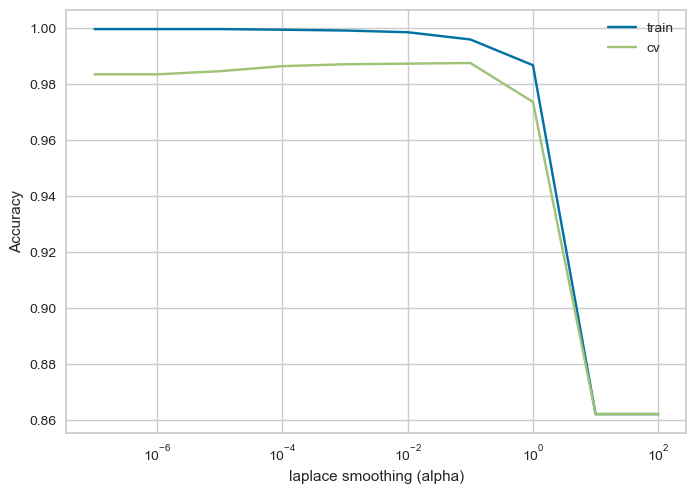

In [41]:
plt.semilogx(alpha_vals, train_scores, label="train")
plt.semilogx(alpha_vals, test_scores, label="cv")
plt.legend()
plt.xlabel("laplace smoothing (alpha)")
plt.ylabel("Accuracy");

### (Optional) Details on the formulas

- In case of `MultinomialNB`, the conditional probabilities will change with the following formula.  

$$ P(w \mid c) = \frac{Count(w, c) + 1 }{Count(c) + \mid vocabulary \mid}$$ 

- In case of Bernoulli naive Bayes, when you calculate conditional probabilities with Laplace smoothing, the formula is slightly different: 

$$ P(w \mid c) = \frac{Count(w, c) + 1 }{Count(c) + 2 }$$ 

- So instead of the $\mid vocabulary \mid$ we just add 2. See the sklearn code [here](https://github.com/scikit-learn/scikit-learn/blob/0d378913b/sklearn/naive_bayes.py#L1031) and [this Stack overflow post](https://stackoverflow.com/questions/40448784/laplace-smoothing-for-bernoulli-model-for-naive-bayes-classifier) for explanation.

Note that when we estimated probabilities in our toy example (e.g., $P(\text{word} \mid spam)$), we happened to have each feature value as either 0 or 1, i.e., just the existence of a word in the document's bag of words. We computed $P(\text{word} \mid spam)$ as a fraction of times the word appears among all words in all messages of the spam class. If we want to work with frequencies instead of existence, we first concatenate all documents with that class (e.g., spam class) into one big "class c" text. Then we use the frequency of the word (e.g., _urgent_ below) in this concatenated document to give a (maximum likelihood) estimate of the probability:

$$P(\text{urgent} \mid \text{spam}) = \frac{Count(\text{urgent}, \text{spam})}{\sum_{w \in vocabulary} Count(w, \text{spam})}$$ 

$$P(\text{urgent} \mid \text{spam}) = \frac{\text{how often _urgent_ occurs with spam}}{\text{total number of tokens (all occurrences of all words) in spam}}$$


<br><br><br><br>

## Naive Bayes with continuous features

- We can use Gaussian Naive Bayes if you have continuous features. 

In [42]:
df = pd.read_csv("data/canada_usa_cities.csv")
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=123
)  # 80%-20% train test split on df
X_train, y_train = train_df.drop(columns=["country"]), train_df["country"]
X_test, y_test = test_df.drop(columns=["country"]), test_df["country"]
train_df.head()

,longitude,latitude,country
160,-76.4813,44.2307,Canada
127,-81.2496,42.9837,Canada
169,-66.0580,45.2788,Canada
188,-73.2533,45.3057,Canada
187,-67.9245,47.1652,Canada


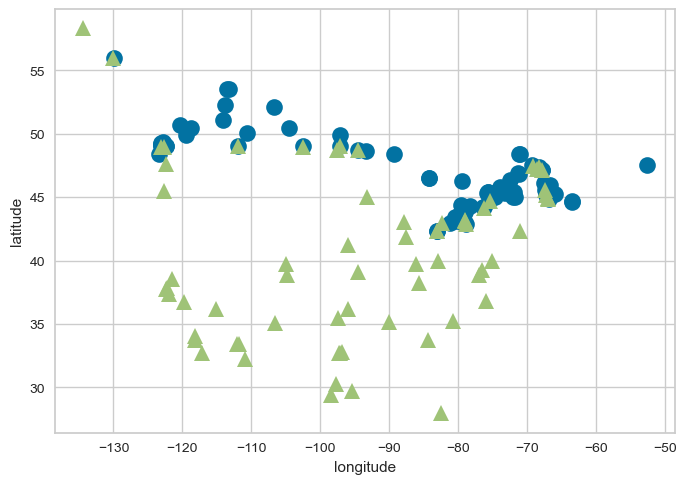

In [43]:
import mglearn

mglearn.discrete_scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], y_train, s=12)
plt.xlabel("longitude")
plt.ylabel("latitude");

###  Gaussian Naive Bayes

- Our cities dataset has continuous-valued features.
- But so far, we've only seen how to use Naive Bayes for discrete features.
- We can either discretize our continuous features into discrete bins (with counts), or...
- Use _Gaussian_ naive Bayes (read more [here](https://machinelearningmastery.com/naive-bayes-for-machine-learning/) and [here](https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Gaussian_naive_Bayes)).
- Here is the general idea of Gaussian naive Bayes:
    - Assume each feature is normally distributed 
    - Calculate the mean ($\mu_k$) and standard deviation ($\sigma_k$) for each feature for each class.
    - Use the following equation to calculate the conditional probability of observing feature value $v$ in class $C_k$

<center>
<img src='./img/gaus_nb.png' width="400">
</center>

Source: [Wikipedia](https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Gaussian_naive_Bayes)

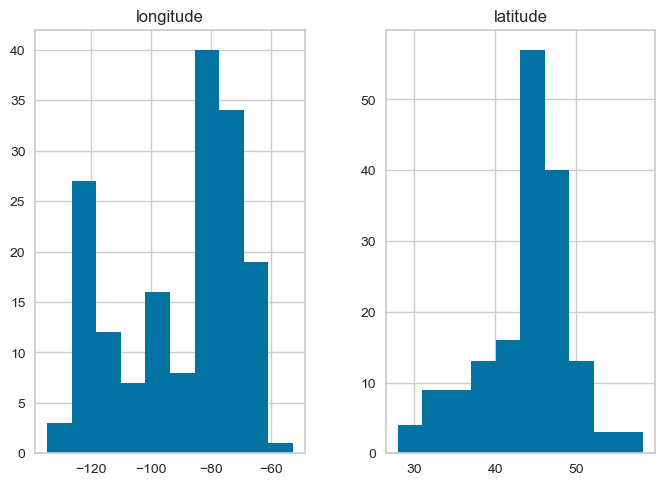

In [44]:
X_train.hist();

- Gaussian naive Bayes assumes normality
    - Are our features normal?
    - Not really but in practice we transform our data to try and make it more normal
    - Scikit-learn provides the `PowerTransformer()` for this process
    - From the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn.preprocessing.PowerTransformer): "*...Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like.*"    

In [45]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method="yeo-johnson")
X_train[["longitude", "latitude"]] = pt.fit_transform(X_train)
X_test[["longitude", "latitude"]] = pt.transform(X_test)

array([[<AxesSubplot: title={'center': 'longitude'}>,
        <AxesSubplot: title={'center': 'latitude'}>]], dtype=object)

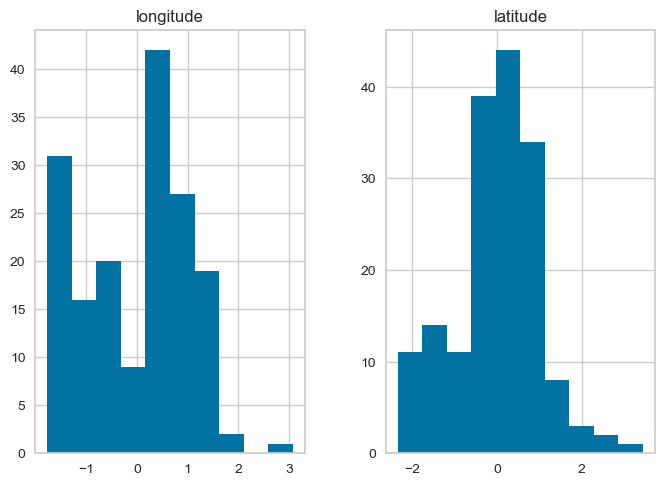

In [46]:
X_train.hist()

In [47]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
cross_val_score(model, X_train, y_train)

array([0.82352941, 0.76470588, 0.72727273, 0.78787879, 0.93939394])

In [48]:
model.fit(X_train, y_train)

GaussianNB()

### (Optional) The generative model behind naive Bayes

- Naive Bayes is a **generative model** because it's modeling the joint distribution over the features $X$ and labels $y$.
- In the next lecture, we'll look at a **discriminative model**, which models $P(y\mid X)$ rather than $P(X,y)$.
- Right now just get familiar with these terms. We'll talk more about them later in the program. 

It's weird to think of the features as random, but we're saying they come from those Gaussians above.

In [49]:
model.class_prior_

array([0.5988024, 0.4011976])

In [50]:
model.sigma_

/Users/kvarada/opt/miniconda3/envs/571/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `sigma_` was deprecated in 1.0 and will be removed in1.2. Use `var_` instead.
  warnings.warn(msg, category=FutureWarning)


array([[1.02394669, 0.39050197],
       [0.84207704, 1.30654508]])

In [51]:
model.theta_

array([[ 0.18122559,  0.40265258],
       [-0.27048596, -0.60097399]])

In [52]:
def gen_gaussian_nb(means, sigmas, p_y, n=500):
    # means:  a 2D array of size num_classes by num features containing the means of the Gaussians
    # sigmas: a 2D array of size num_classes by num features containing the standard deviations of the Gaussians
    # p_y   : a 1D array of length num_classes containing the probability of each class
    # n     : an integer for the number of samples ("size of sample") to generate

    C = 2 # number of classes
    d = 2 # number of features
    X_generated = np.zeros((n,d))
    y_generated = np.zeros((n))
    for i in range(n):
        # pick Canadian city/USA city
        k = np.random.choice(C, p=p_y)
        for j in range(d):
            X_generated[i,j] = means[k,j] + sigmas[k,j] * np.random.randn()
        y_generated[i] = k    
        
    return X_generated, y_generated

In [53]:
X_generated, y_generated = gen_gaussian_nb(model.theta_, np.sqrt(model.sigma_), model.class_prior_)

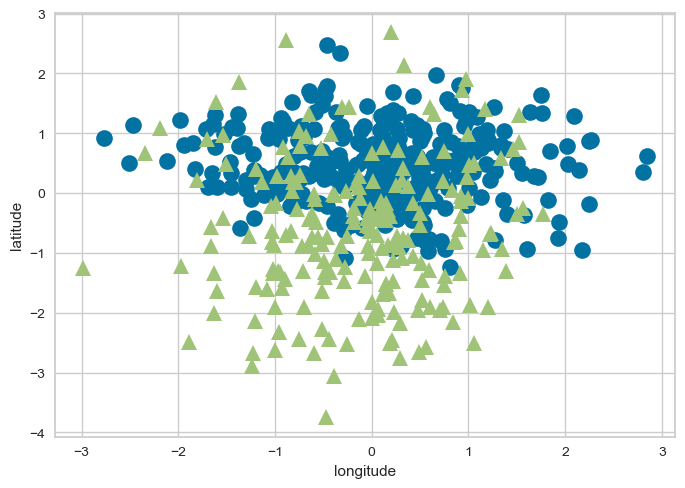

In [54]:
mglearn.discrete_scatter(X_generated[:, 0], X_generated[:, 1], y_generated, s=12)
plt.xlabel("longitude")
plt.ylabel("latitude");

We can experiment with different priors. 

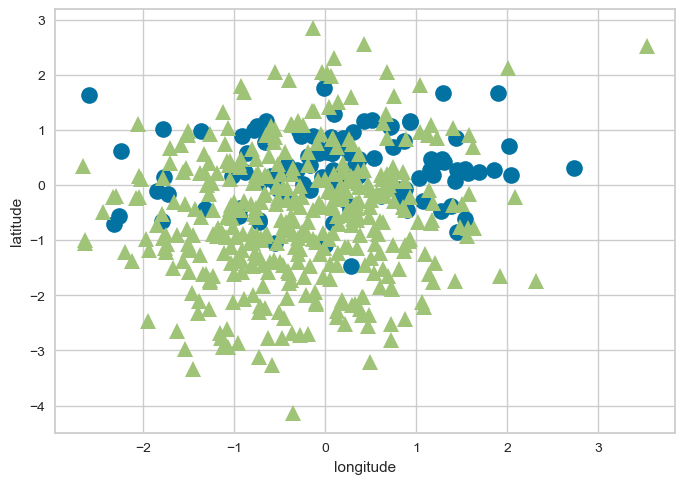

In [55]:
X_generated, y_generated = gen_gaussian_nb(model.theta_, np.sqrt(model.sigma_), [0.2,0.8])
mglearn.discrete_scatter(X_generated[:, 0], X_generated[:, 1], y_generated, s=12)
plt.xlabel("longitude")
plt.ylabel("latitude");

<br><br><br><br>

## Naive Bayes on multi-class problems 

Let's use `sklearn`'s inbuilt 20 newsgroups dataset. It comprises around 18,000 newsgroups posts on 20 topics. So it's a 20-class classification problem. 

In [56]:
from sklearn import datasets
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(
    subset="train", remove=("headers", "footers", "quotes")
)
newsgroups_test = fetch_20newsgroups(
    subset="test", remove=("headers", "footers", "quotes")
)
X_news_train, y_news_train = newsgroups_train.data, newsgroups_train.target
X_news_test, y_news_test = newsgroups_test.data, newsgroups_test.target

Here are the 20 topics (targets or classes) in the dataset. 

In [57]:
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### Let's try `DummyClassifier`

In [58]:
dummy = DummyClassifier()
scores = cross_validate(dummy, X_news_train, y_news_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.001129,0.000198,0.053027,0.053033
1,0.000799,0.000127,0.053027,0.053033
2,0.000787,0.000118,0.053027,0.053033
3,0.000799,0.000126,0.053027,0.053033
4,0.000739,0.000116,0.053050,0.053027


The scores are very low because we have 20 different classes!! 

### Let's try `MultinomialNB`

In [59]:
pipe_multi = make_pipeline(CountVectorizer(), MultinomialNB())
scores = cross_validate(pipe_multi, X_news_train, y_news_train, return_train_score=True)

In [60]:
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.621400,0.137221,0.583738,0.741465
1,0.612037,0.150600,0.570040,0.739587
2,0.598725,0.131178,0.583297,0.749309
3,0.625302,0.130457,0.571365,0.731963
4,0.599697,0.127776,0.588859,0.739063


The validation scores are low but much better than the `DummyClassifier`.  

Let's try to predict on an example. 

In [61]:
pipe_multi.fit(X_news_train, y_news_train);

In [62]:
print(X_news_test[100])
prediction = pipe_multi.predict([X_news_test[100]])[0]
print(
    "Prediction index: %d and prediction class: %s"
    % (prediction, newsgroups_train.target_names[prediction])
)

Hello All!

    It is my understanding that all True-Type fonts in Windows are loaded in
prior to starting Windows - this makes getting into Windows quite slow if you
have hundreds of them as I do.  First off, am I correct in this thinking -
secondly, if that is the case - can you get Windows to ignore them on boot and
maybe make something like a PIF file to load them only when you enter the
applications that need fonts?  Any ideas?


Chris
Prediction index: 5 and prediction class: comp.windows.x


And here are prediction probabilities. 

In [63]:
pipe_multi.predict_proba([X_news_test[100]])

array([[7.26904475e-19, 1.48743104e-10, 4.16538604e-28, 2.96340768e-10,
        1.91391647e-14, 1.00000000e+00, 4.34194388e-28, 2.40916532e-18,
        9.74009600e-22, 1.72603033e-31, 5.61184330e-31, 8.76853929e-14,
        1.00705690e-16, 2.70331089e-13, 2.36762710e-21, 5.91222397e-16,
        3.61589511e-15, 1.49715839e-13, 2.92789387e-16, 1.20413840e-24]])

### General comments on naive Bayes

- Family of probabilistic classifiers 
- GausianNB is used on very high dimensional numeric data
- BernoulliNB and MultinomialNB are used for sparse data (e.g., text data). 
    - MultinomialNB usually performs better than BernoulliNB, especially when you are working with large documents.
    - Complexity hyperparameter: `alpha`

### General comments on naive Bayes

- A fast and robust way to learn the corresponding parameters
- Training procedure is easy to understand 
- Surprising accuracy considering its simplicity
- Scales great; learning a naive Bayes classifier is just a matter of counting how many times each attribute co-occurs with each class
- Can be easily used for multi-class classification

### General comments on naive Bayes

- It's closely related to linear classifiers, which we'll see in the next lecture. 
    - When we take the logarithms, the products turn into summations. 
- Can provides a informative set of features from which to predict the class (next class)

### General comments on naive Bayes

- Often provide generalization performance that is slightly worse 
- Assumes that spammers generate e-mails by picking words at random. It means that sentences have no syntax and content. Is that a fair assumption? 
    - oversimplification 
    - sometimes the best theories are the most oversimplified 🤷🏻‍♀️

- Although naive Bayes is known as a decent classifier, it is known to be a **bad estimator**, so the probability outputs from `predict_proba` are not to be taken too seriously.

### Reflection

Write your reflections (takeaways, struggle points, and general comments) on this material in [the reflection Google Document](https://docs.google.com/document/d/1McJCxNkXWfxwSch-DSwXqHS0nyTax7ASt5QJiUFJhPc/edit?usp=sharing) so that I'll try to address those points in the next lecture. 

![](img/eva-seeyou.png)
